(mmm_lift_test)=

# Lift Test Calibration

## Introduction

You may have heard of the phrase "[All models are wrong but some are useful.](https://en.wikipedia.org/wiki/All_models_are_wrong)" This is true in many areas, and it's likely that after the first attempt, you haven't yet created a model that can accurately determine your true attribution. Even if you have, how can you be sure? We create models to understand the attribution of our marketing channels, but it appears that even then, we can't always rely on what the models tell us.

In order to ensure that our models are decomposing correctly, we can use various testing methods to gather real-world data and compare it with our models. This will help us to identify any discrepancies and improve the decomposition accuracy of our models. 

Today, we will explore a new way to integrate experiments into **pymc-marketing**. This will bring us closer to accurate representations of real-world values and improve the estimates generated by our models.

## When are lift test useful?

In some situations, all of the relevant experiment spend data is captured within historical data that you will including in your training set. In these cases, a valid approach would be to simply train your MMM on all available data (including experiment and non-experiment periods) in order to optimally inform your about model parameters and ultimately get better insights. However there are a number of situations when this approach will not be appropriate.

1. Imagine your online advertising platform gave you additional credit. You decide to spend this credit by increasing spend on a digital channel and you want to use this as a way to evaluate the uplift. In this situation, you will have increased the level of advertising taking place, but this 'increased spend' is not charged to your invoice. So unless your data pipeline is really on point, your spend data will not accurately reflect the level of actual effective spend.

2. You want to run a test on TV. In that case, you probably have to pay months before the test takes place or the commercial is aired. So, your spending may be in February and the action in March, but during the period of the experiment itself, there is no spending. Here, the spend may well be contained in your training data, but the time lag between the spend and the advertising takes place is very high, and there is nothing in the MMM to account for this.

3. You are experimenting with discounts or promotions. These might be quantifiable, but not show up in your traditional media spend channels and so your experimentation may not be captured by your MMM.

These are just a few examples where lift tests can be useful. In these cases, you can use the results of the lift test to adjust the model parameters and improve the accuracy of the model.

## Requirements

Today, we won't be discussing how to conduct lift tests, but instead, we will focus on their utilization. If you wish to acquire knowledge on how to generate results that are compatible with your MMM models, you can check out [CausalPy](https://causalpy.readthedocs.io/en/latest/) for conducting experiments.

## Goal

After reading this notebook, you will have gained the necessary expertise to incorporate the results (detected uplift from your experiments) into our regressive model.

This notebook will display using the `add_lift_test_measurements` method of `MMM` and its workflow:

1. Build model: `mmm.build_model(X, y)`
2. Add lift measurements: `mmm.add_lift_test_measurements(df_lift_test)`
2. Sample posterior: `mmm.fit(X, y)`

This is a case study of two correlated channels to see how lift tests help distinguish the channel effects.

In [1]:
import warnings
from functools import partial

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import logistic_saturation

In [2]:
warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%config InlineBackend.figure_format = 'retina'

In [3]:
seed = sum(map(ord, "Lift tests help distinguish channel effects"))
rng = np.random.default_rng(seed)

## Generate Correlated Spends and Model Target

First we'll generate synthetic data for two channels with completely correlated spends.


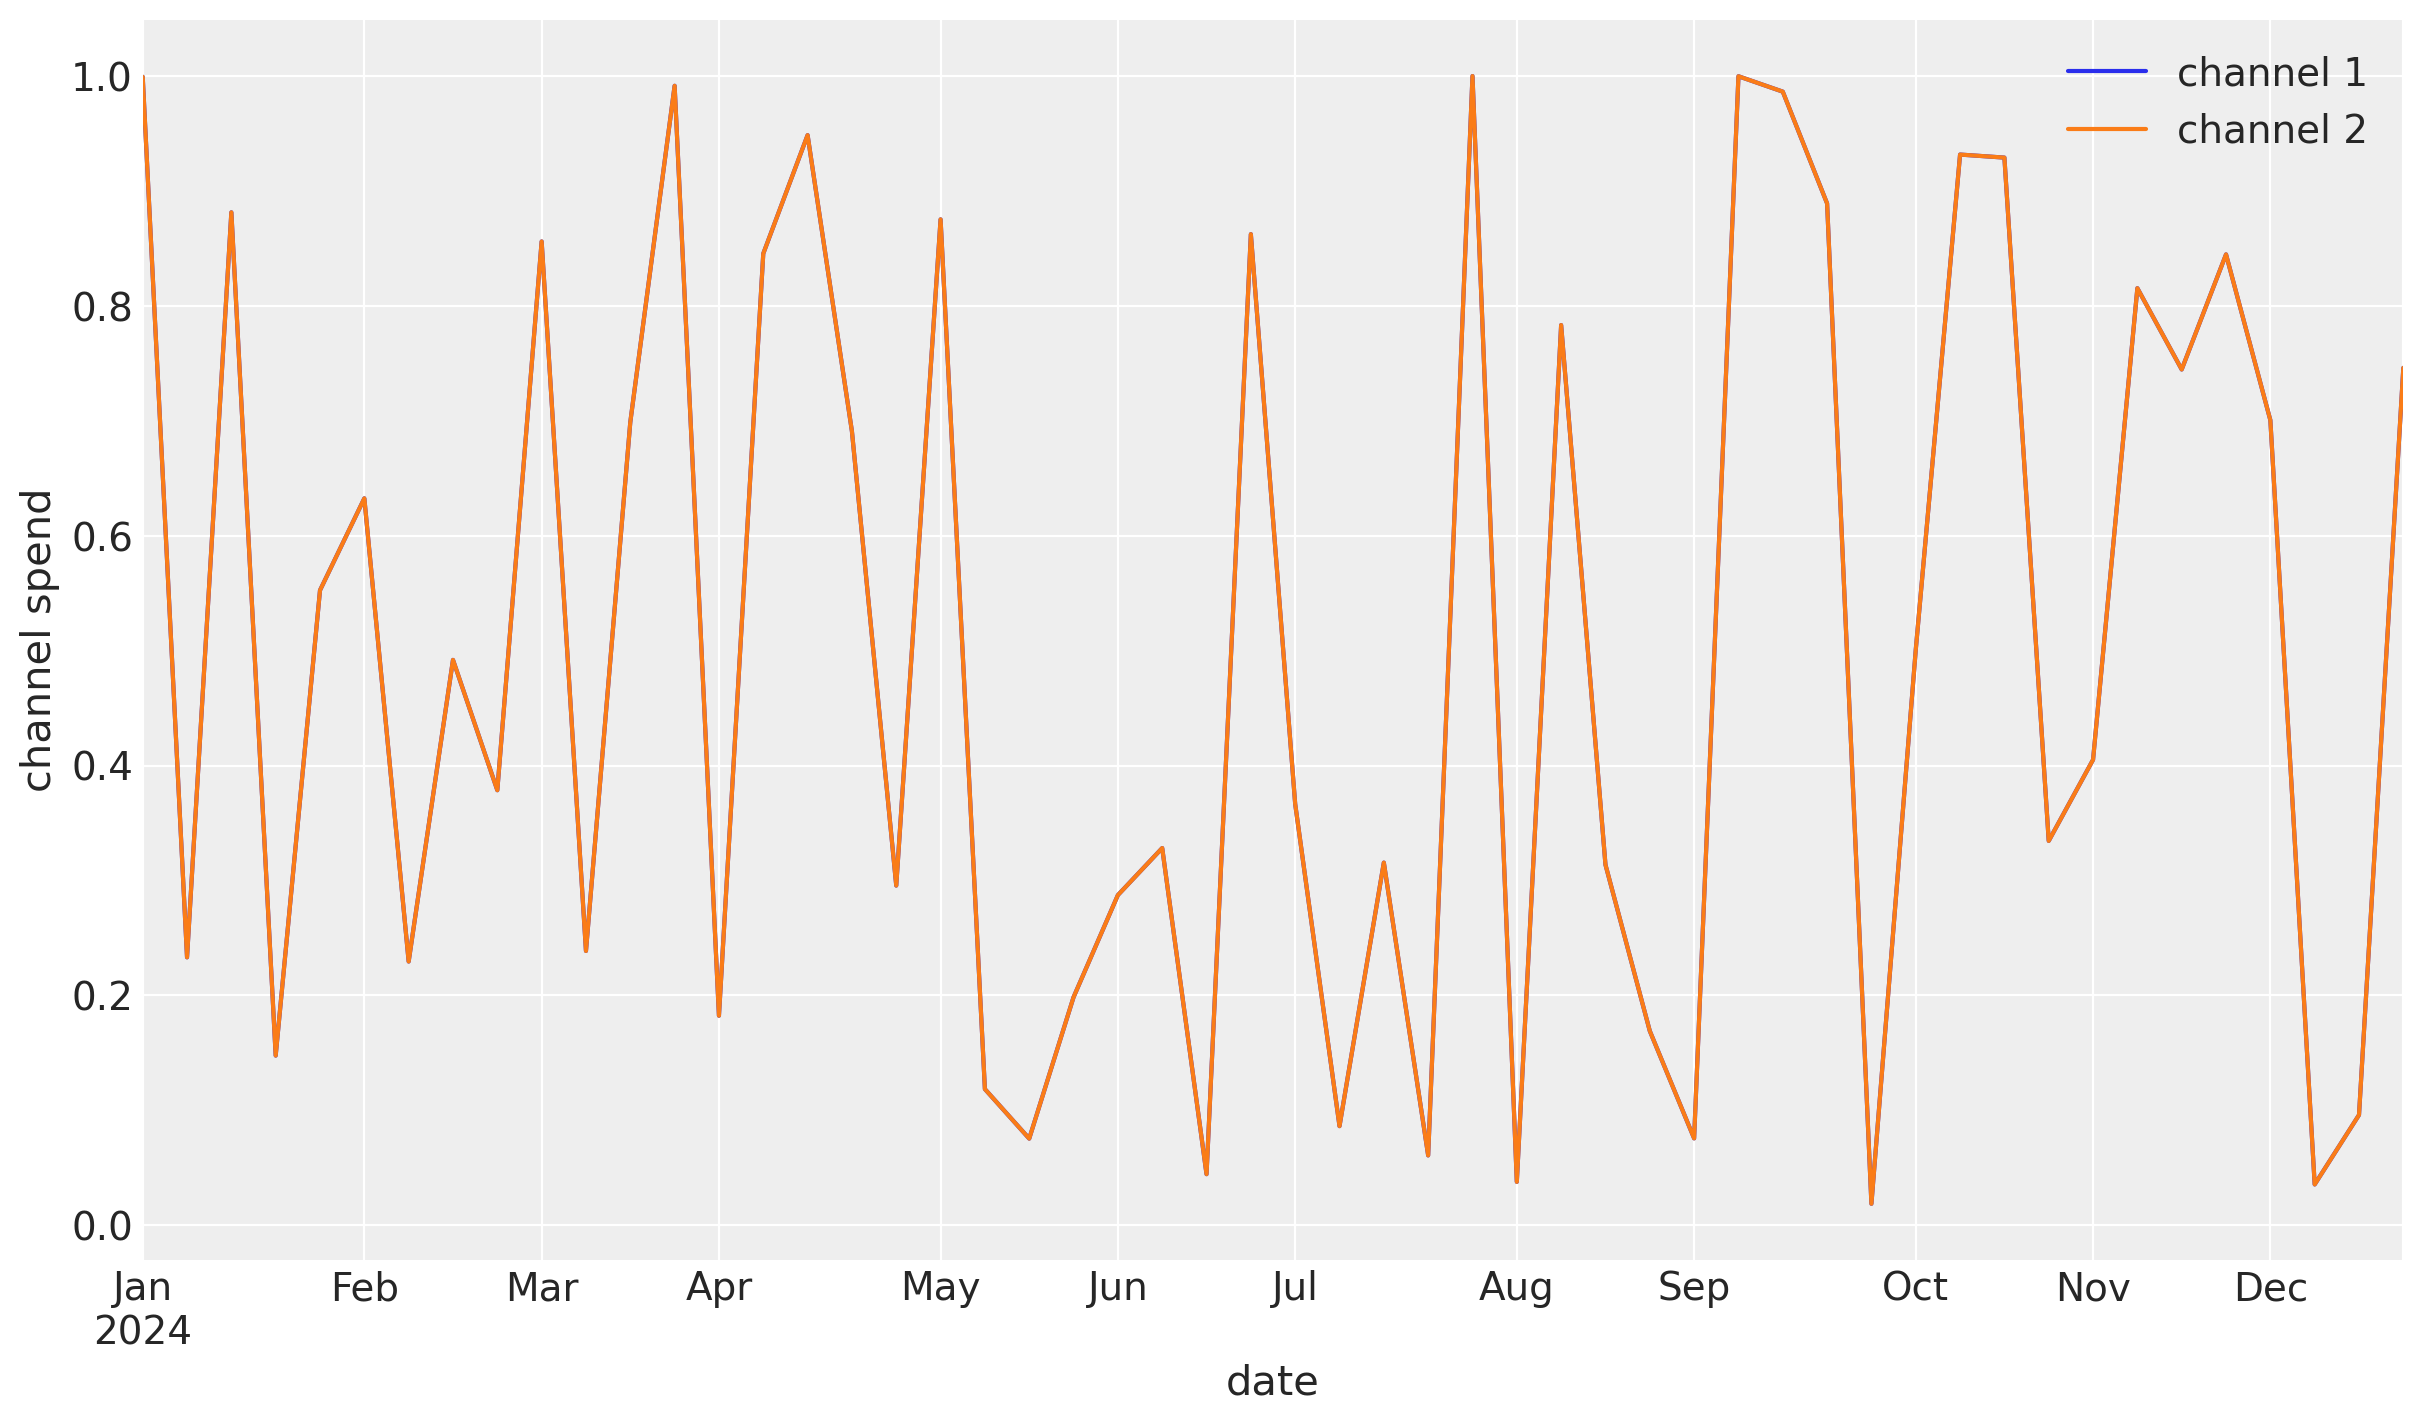

In [4]:
n_dates = 52
dates = pd.date_range(start="2024-01-01", periods=n_dates, freq="W-MON")
spend_rv = pm.Uniform.dist(lower=0, upper=1, size=n_dates)
spend = pm.draw(spend_rv, random_seed=rng)
spend /= spend.max()
df = pd.DataFrame(
    {
        "date": dates,
        "channel 1": spend,
        "channel 2": spend,
    }
)

ax = df.set_index("date").plot(ylabel="channel spend");

:::{note}
For this example, the synthetic spend data is not produced in a overly realistic manner. However, we have normalized the maxmium spend to 1 for each channel to mimmick data pre-processing that typically takes place in a pymc-marketing workflow.
:::

We can double check that the to channels are perfectly correlated.

In [5]:
df.filter(regex="channel").corr()

,channel 1,channel 2
channel 1,1.0,1.0
channel 2,1.0,1.0


We use the `MMM` class to specify our model just as usual. 

In [6]:
mmm = MMM(
    date_column="date",
    channel_columns=["channel 1", "channel 2"],
    adstock=GeometricAdstock(l_max=6),
    saturation=LogisticSaturation(),
)

For this constructed example, we will set parameter of the model with the `pm.do` operator and take a random sample of the target variable. The fixed parameters are below which we will try to recover.

At this point, a model has not been fit. However, we have created our data set to fit our model on.

In [7]:
true_lam_c1 = 10
true_beta_c1 = 0.55

true_lam_c2 = 1.5
true_beta_c2 = 1.0

true_params = {
    "adstock_alpha": [0.5, 0.5],
    "saturation_lam": [true_lam_c1, true_lam_c2],
    "saturation_beta": [true_beta_c1, true_beta_c2],
    "intercept": 0.5,
    "y_sigma": 0.25,
}

In [8]:
mmm.build_model(df.reset_index(), y=np.ones(n_dates))
fixed_model = pm.do(mmm.model, true_params)
df["y"] = pm.draw(fixed_model["y"], random_seed=rng)
del mmm.model

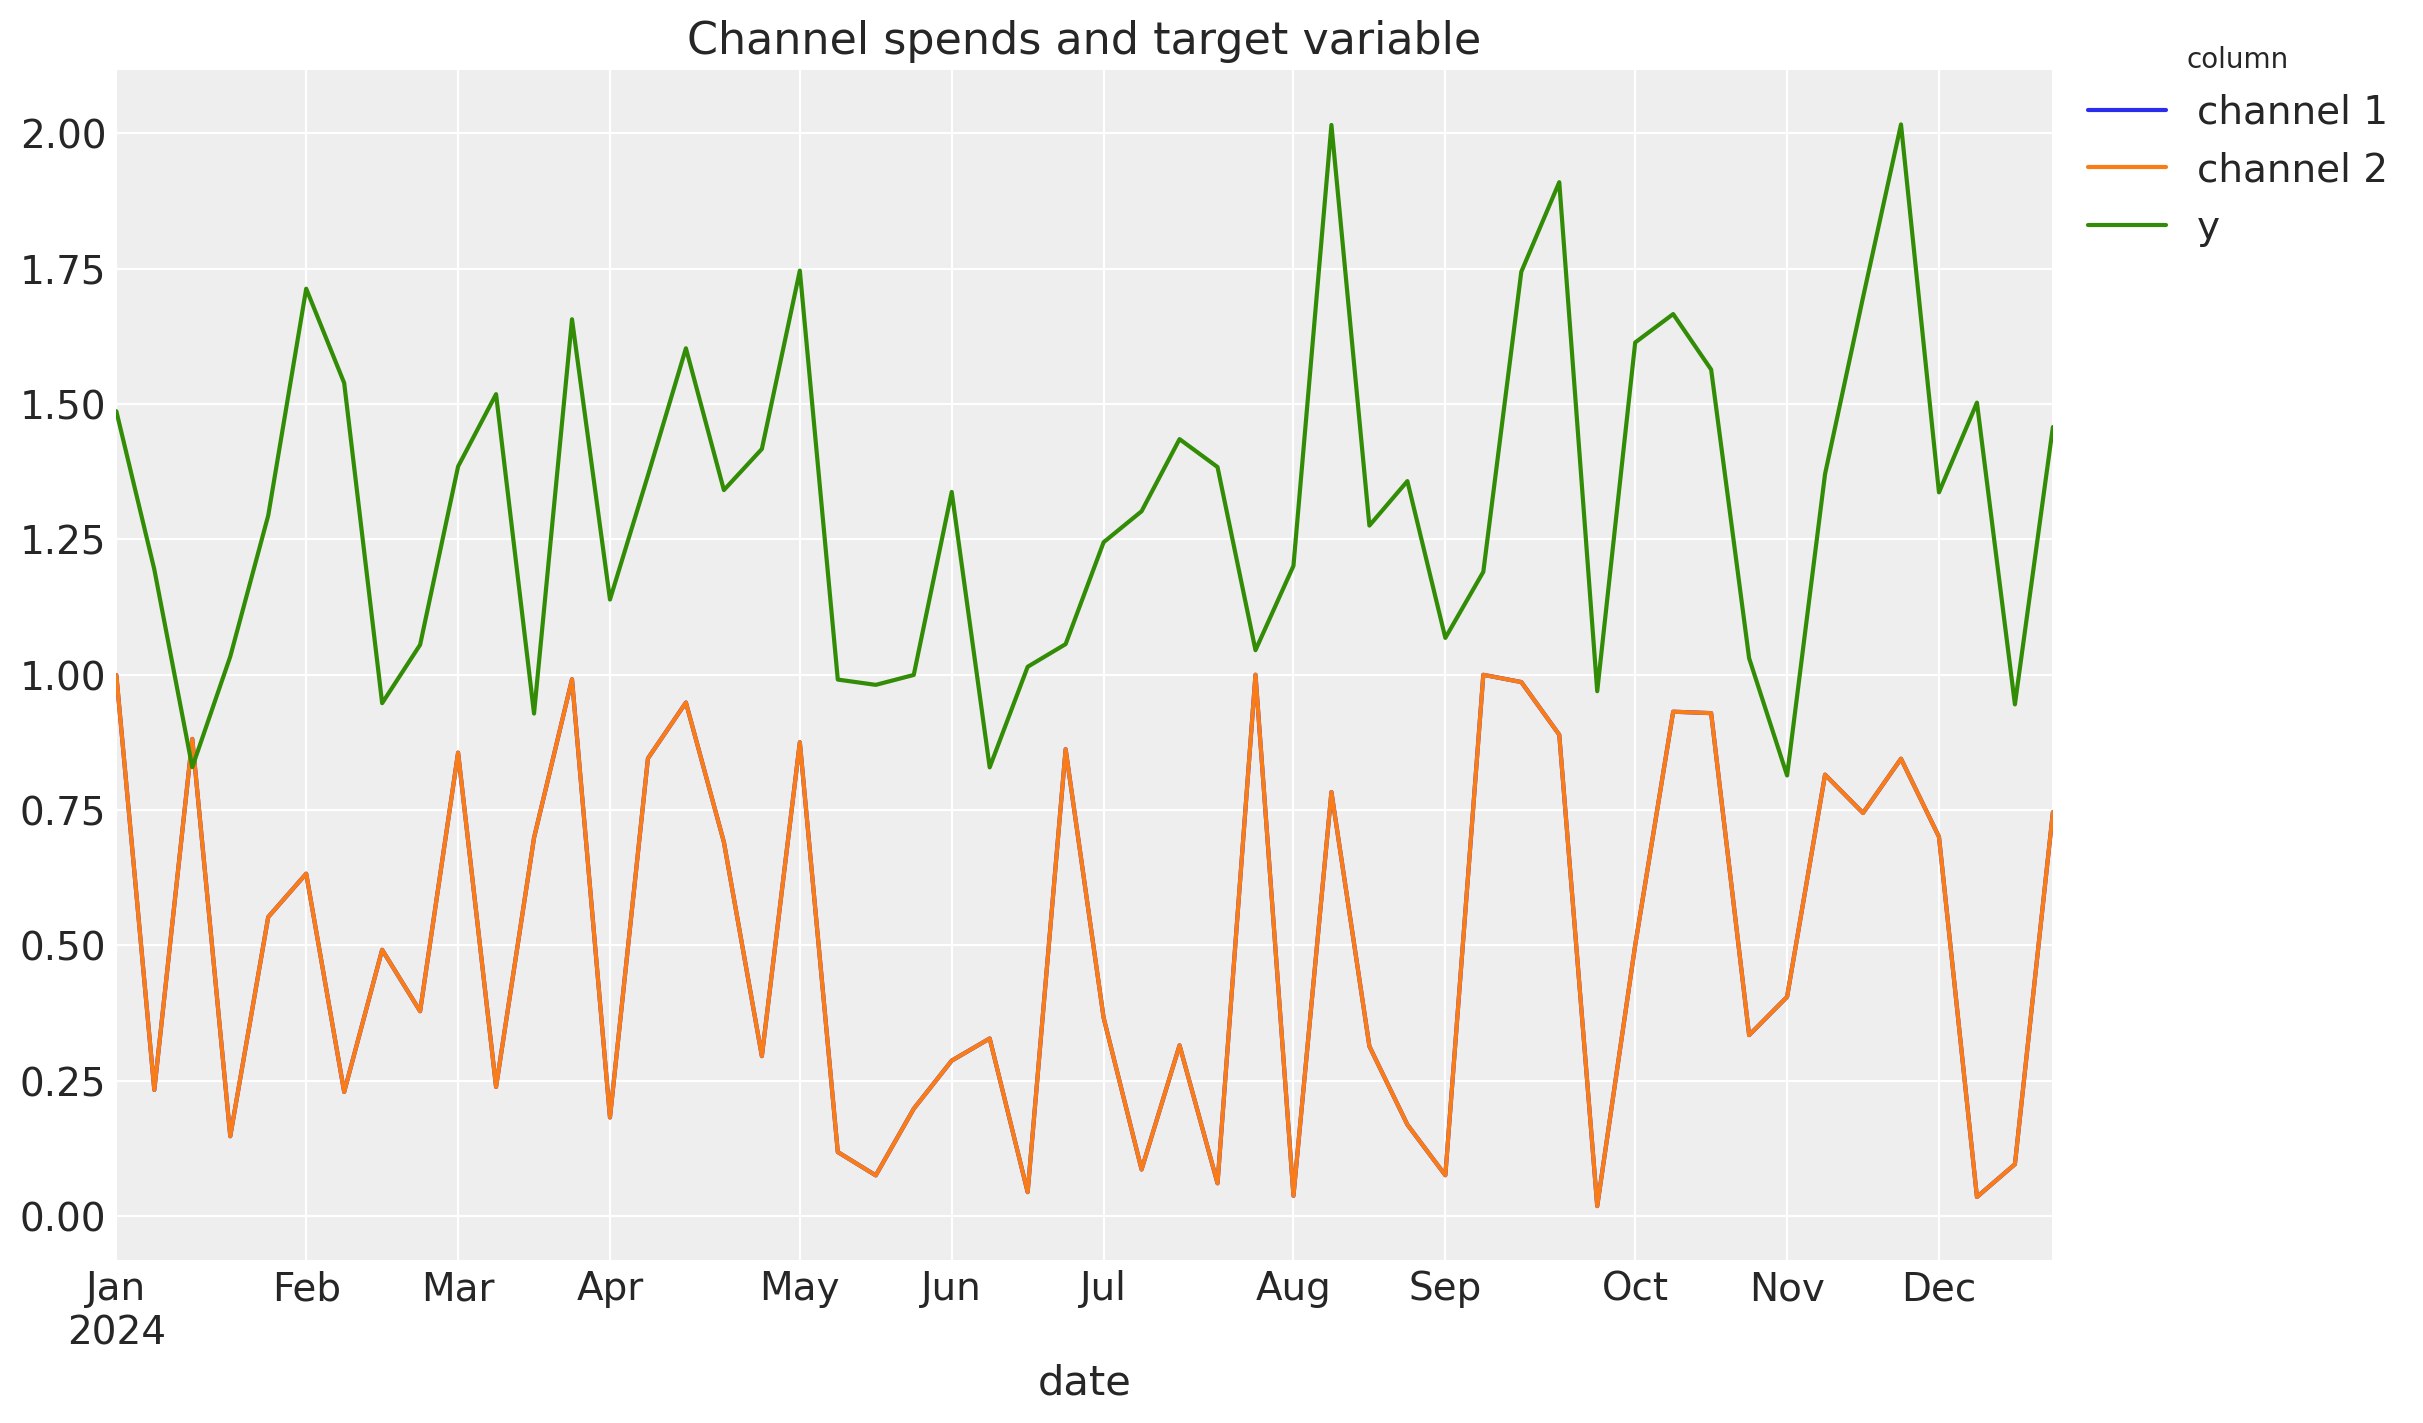

In [9]:
ax = df.set_index("date").plot(ylabel="", title="Channel spends and target variable")
ax.legend(bbox_to_anchor=(1.0, 1.05), title="column");

In [10]:
X = df.reset_index().drop("y", axis=1)
y = df["y"]

## Indistinguishable Parameter Estimates

In order to show the trouble that completely correlated channels provides, let's fit the model

In [11]:
fit_kwargs = {"nuts_sampler": "numpyro", "random_seed": rng}

idata_without = mmm.fit(X, y, **fit_kwargs)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 34 divergences after tuning. Increase `target_accept` or reparameterize.


Since the spends are completely correlated, there is no way to distinguish the parameters. Not only that, but the parameter estimates are not close to actuals.

In [12]:
def plot_true_value(value, channel: str, ax: plt.Axes, split: float = 0.42) -> plt.Axes:
    top = 2 * split
    ymin, ymax = (0, split) if channel == "channel 2" else (split, top)
    ax.axvline(value, ymin=ymin, ymax=ymax, color="black", linestyle="dashed")
    return ax

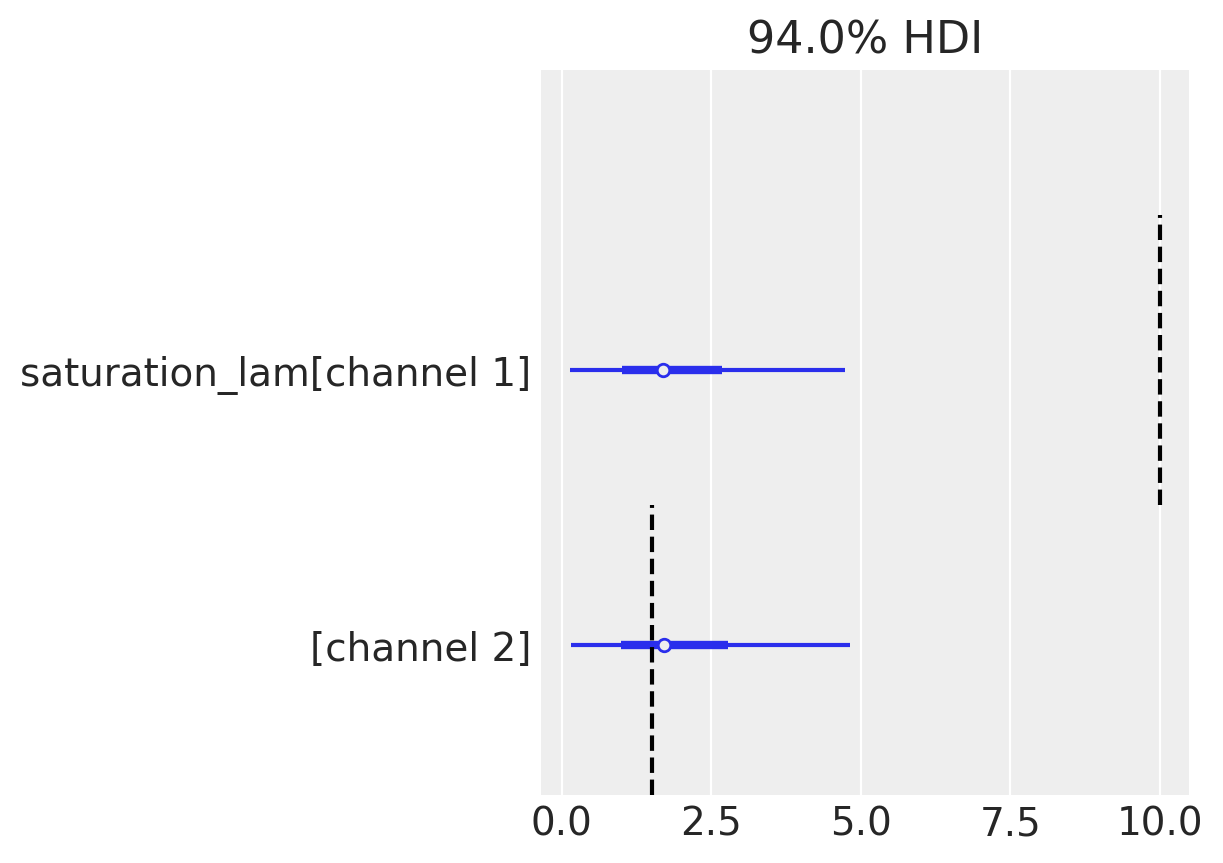

In [13]:
ax = az.plot_forest(idata_without, var_names=["saturation_lam"], combined=True)[0]

plot_true_value(true_lam_c1, "channel 1", ax=ax, split=0.4)
plot_true_value(true_lam_c2, "channel 2", ax=ax, split=0.4);

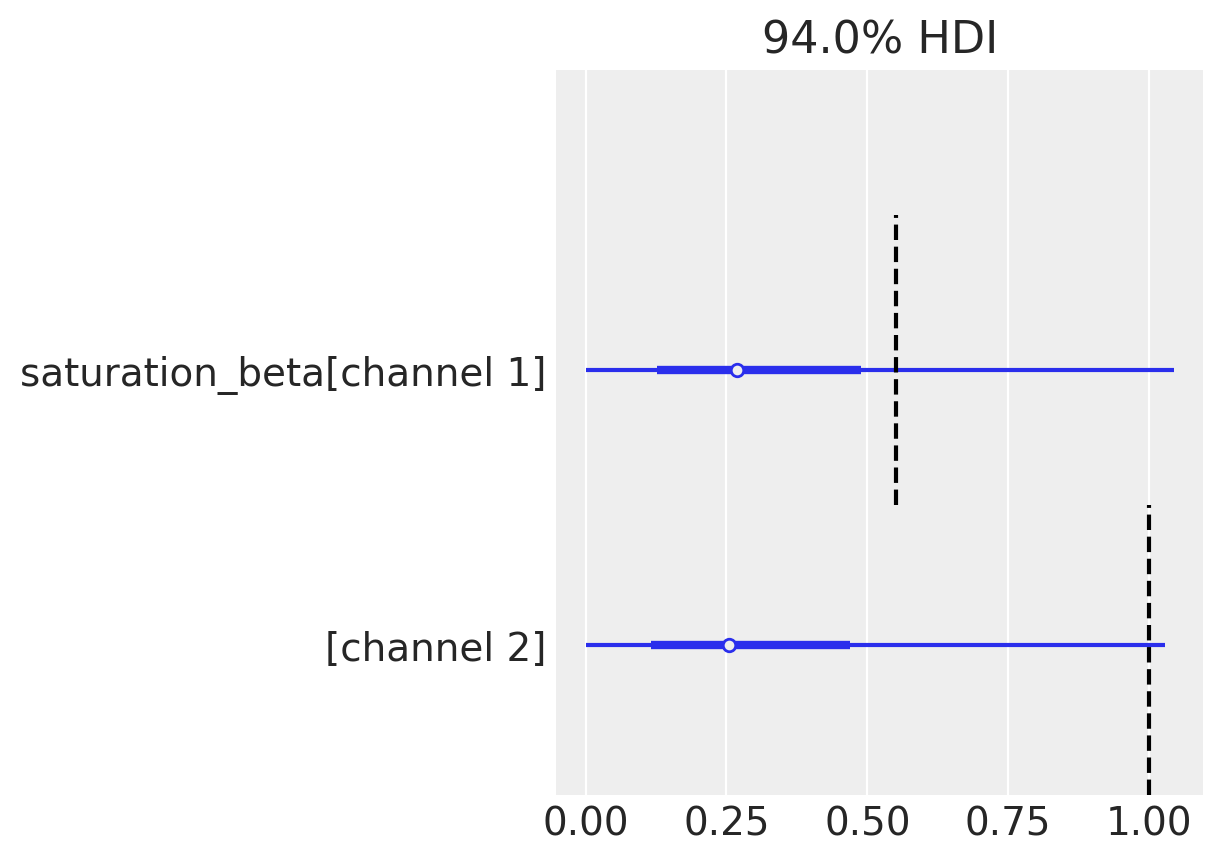

In [14]:
ax = az.plot_forest(idata_without, var_names=["saturation_beta"], combined=True)[0]

plot_true_value(true_beta_c1, "channel 1", ax=ax, split=0.4)
plot_true_value(true_beta_c2, "channel 2", ax=ax, split=0.4);

We can also witness that while the actual saturation curves are different (because we specified the true parameters for each channel), the MMM is unable to distinguish between the two channels.

We can show this below by plotting the actual saturation curves (lines) and the direct response curves (points).

:::{admonition} Direct response curves
:class: tip

Plots the direct contribution curves for each marketing channel. The term "direct" refers to the fact we plot costs vs immediate returns and we do not take into account the lagged effects of the channels e.g. adstock transformations. And so these curves will actually consist of a series of points, each representing the direct contribution of a spend level.
:::

In [15]:
def saturation_function(x, lam, beta):
    return (beta * logistic_saturation(x, lam)).eval()


step_size = 0.05
xx = np.arange(0, spend.max() * 1.1, step_size)

c1_curve_fn = partial(saturation_function, lam=true_lam_c1, beta=true_beta_c1)
c2_curve_fn = partial(saturation_function, lam=true_lam_c2, beta=true_beta_c2)

c1_curve = c1_curve_fn(xx)
c2_curve = c2_curve_fn(xx)


def plot_actual_curves(ax: plt.Axes, linestyle: str | None = None) -> plt.Axes:
    ax.plot(xx, c1_curve, label="channel 1", color="C0", linestyle=linestyle)
    ax.plot(xx, c2_curve, label="channel 2", color="C1", linestyle=linestyle)

    return ax


def plot_reference(ax: plt.Axes) -> plt.Axes:
    ax.plot(xx, xx, label="y=x", color="black", linestyle="--")

    return ax

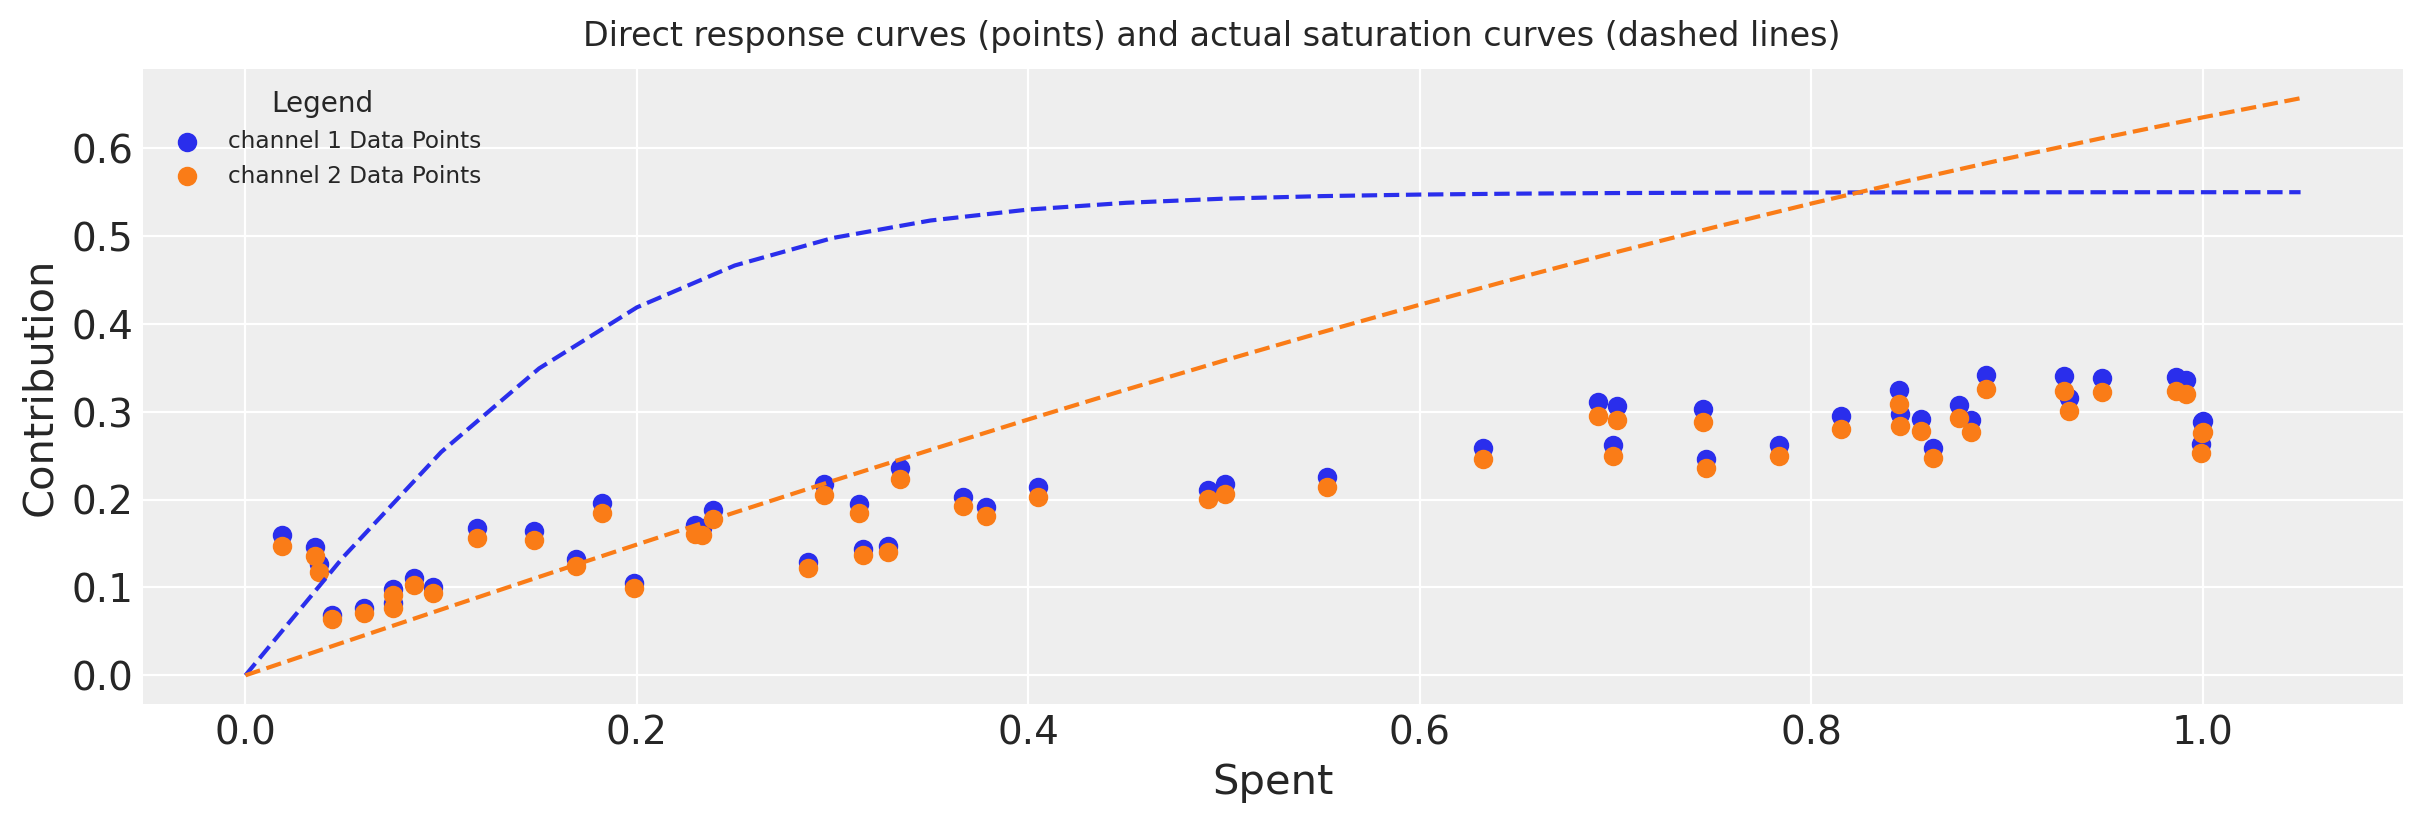

In [16]:
fig = mmm.plot_direct_contribution_curves(same_axes=True)
ax = fig.axes[0]
plot_actual_curves(ax=ax, linestyle="dashed")
ax.figure.suptitle(
    "Direct response curves (points) and actual saturation curves (dashed lines)"
);

We can see that the true but latent saturation curves (dashed lines) for each channel are different, but that the the MMM is unable to distinguish that the saturation curves for each channel (points) are different. And this is because the spends are perfectly correlated. 

Let's see if we can improve upon this by adding lift test measurements.

:::{note}
In order to avoid confusion with the plot above, the actual saturation curves are represented by the dashed lines, while the direct contribution curves are represented by the points. If lift tests can help us in this situation of high spend correlation, then we should be able to detect this by: a) achieving better parameter estimates, and b) correspondingly, getting better estimates of the saturation curves.
:::

## About Lift Tests

In a lift study, one temporarily changes the budget of a channel for a fixed period of time, and then uses some method (for example CausalPy) to make inference about the change in sales directly caused by the adjustment.

A lift test is characterized by:

- `channel`: the channel that was tested
- `x`: pre-test channel spend
- `delta_x`: change made to `x`
- `delta_y`: inferred change in sales due to `delta_x`
- `sigma`: standard deviation of `delta_y`

An experiment characterized in this way can be viewed as two points on the saturation curve for the channel. Accordingly, lift test calibration is implemented by adding a term to the model likelihood, that makes the channel saturation curve (the contribution as a function of spend) align with the test observation.

In [17]:
def create_lift_test_from_actual_curve(
    channel: str, x: float, delta_x: float, sigma: float
) -> dict[str, float]:
    curve_fn = c1_curve_fn if channel == "channel 1" else c2_curve_fn
    delta_y = curve_fn(x + delta_x) - curve_fn(x)

    return {
        "channel": channel,
        "x": x,
        "delta_x": delta_x,
        "delta_y": delta_y,
        "sigma": sigma,
    }

In [18]:
df_lift_test = pd.DataFrame(
    [
        # Channel x1
        create_lift_test_from_actual_curve("channel 1", 0.05, 0.05, 0.05),
        create_lift_test_from_actual_curve("channel 1", 0.15, 0.05, 0.05),
        create_lift_test_from_actual_curve("channel 1", 0.3, 0.05, 0.05),
        # Channel x2
        create_lift_test_from_actual_curve("channel 2", 0.5, 0.05, 0.10),
    ]
)

df_lift_test

,channel,x,delta_x,delta_y,sigma
0,channel 1,0.05,0.05,0.119459,0.05
1,channel 1,0.15,0.05,0.069545,0.05
2,channel 1,0.30,0.05,0.019925,0.05
3,channel 2,0.50,0.05,0.032236,0.10


Let's visualise the lift test results to get an understanding of how they can better inform the model parameters - specifically the saturation curve parameters.

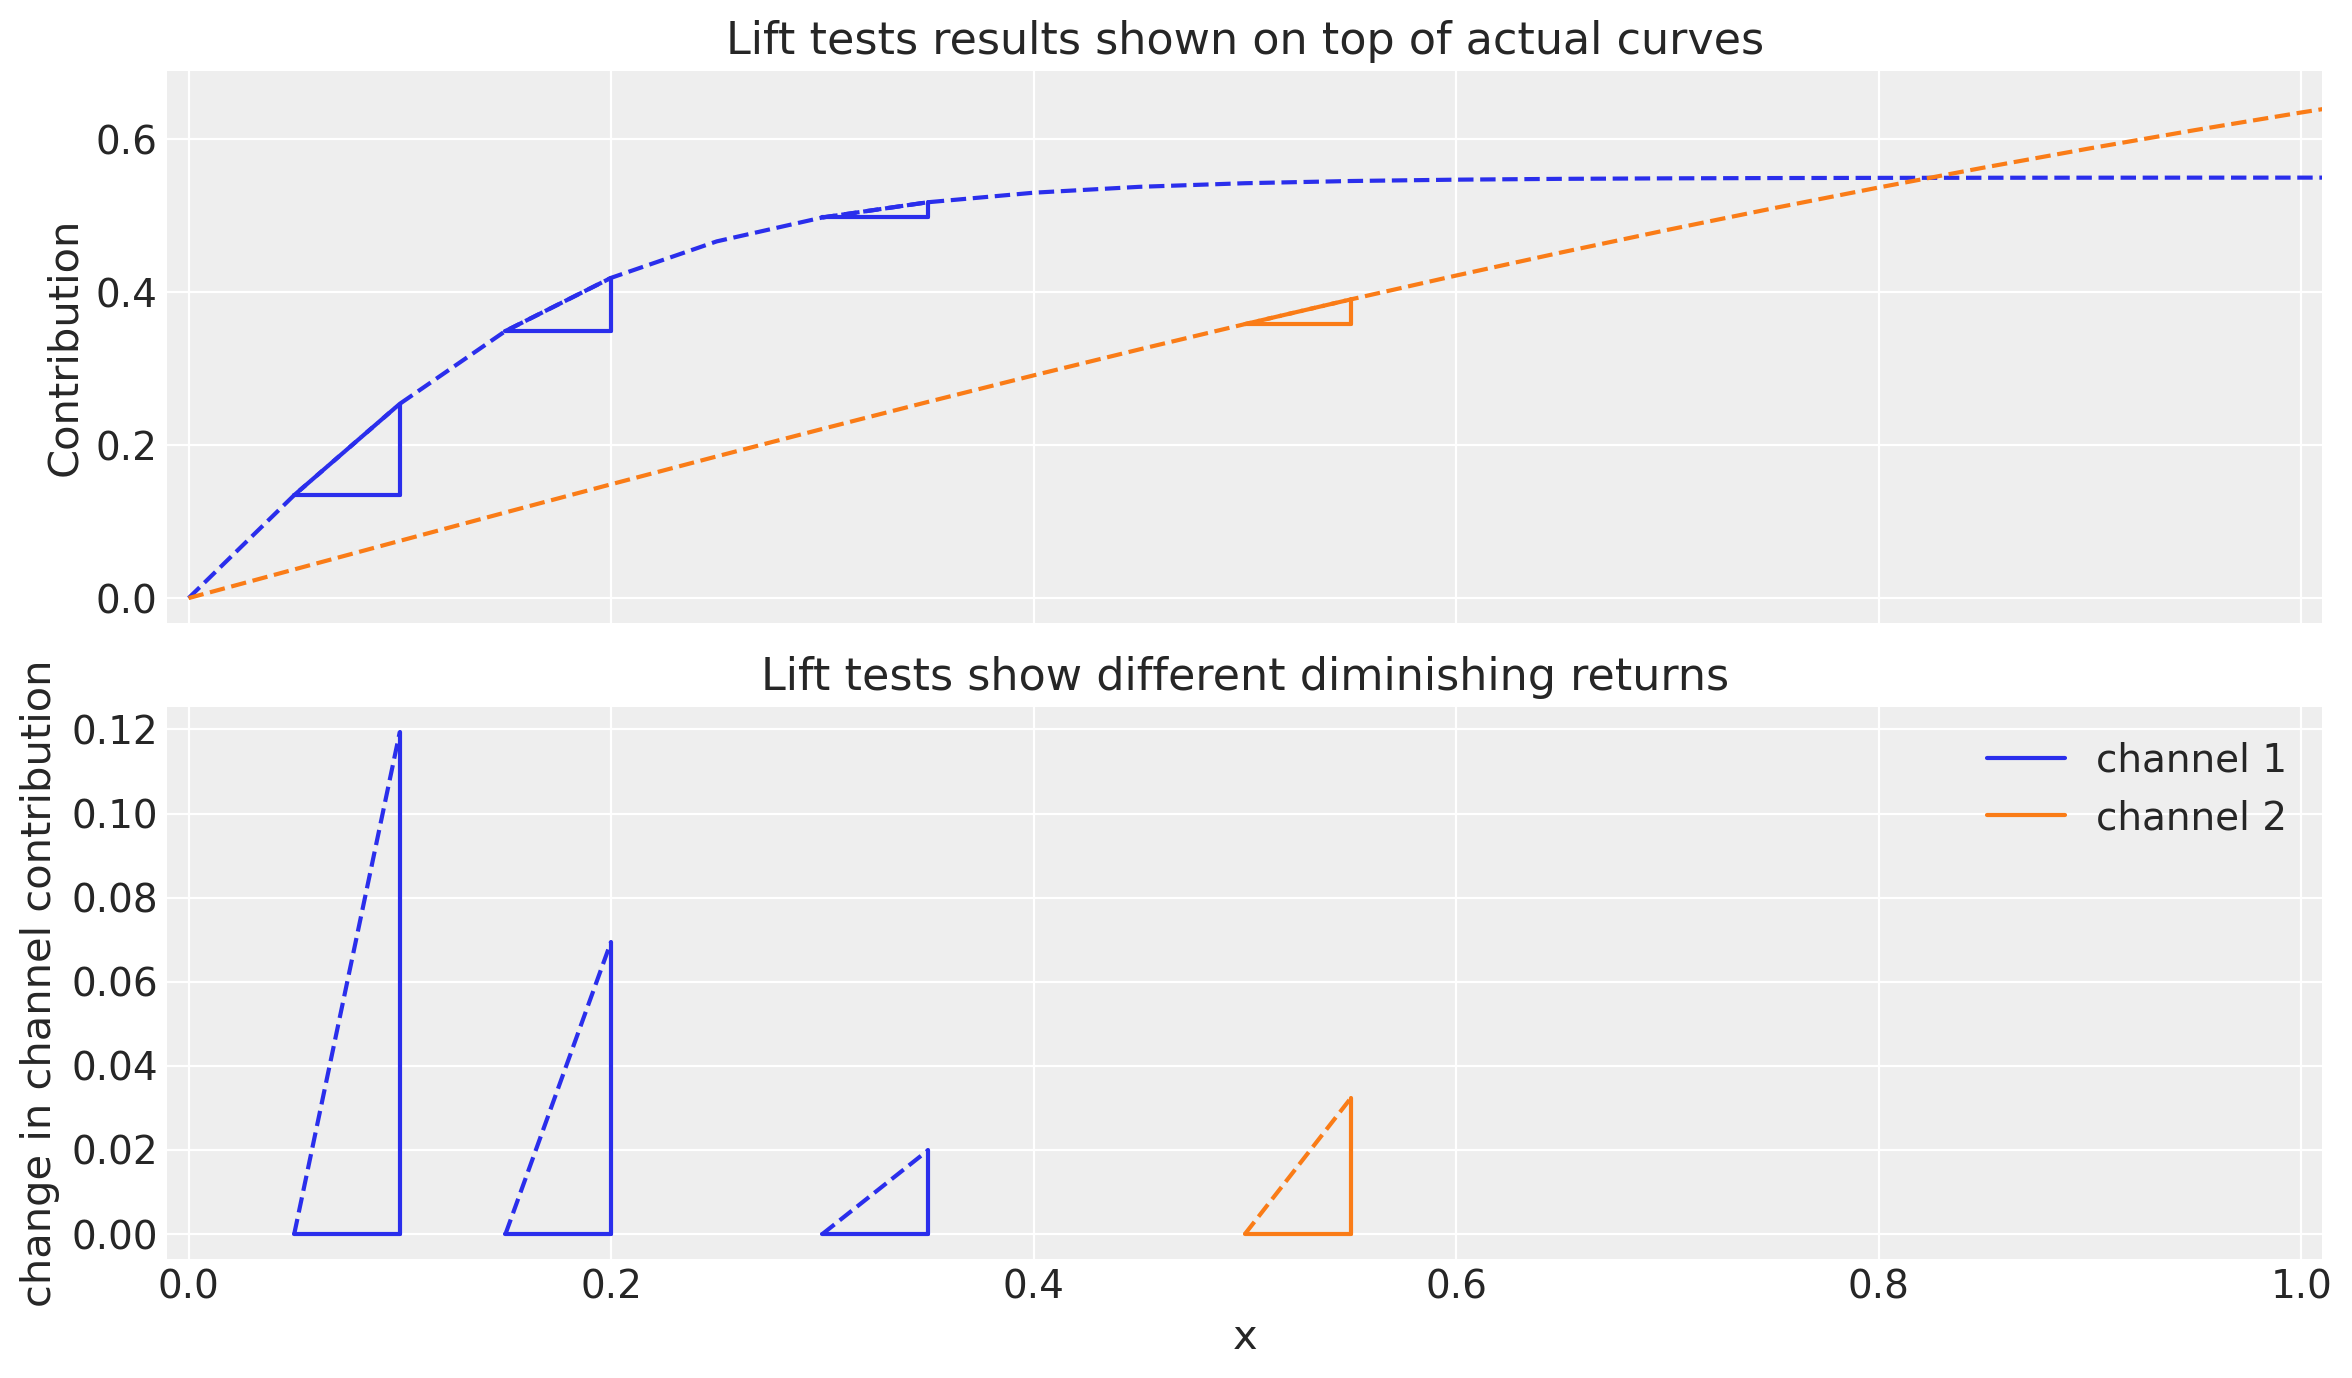

In [19]:
def plot_triangle(
    x,
    delta_x,
    delta_y,
    color: str,
    ax: plt.Axes,
    offset: float = 0,
    label: str | None = None,
) -> plt.Axes:
    x_after = x + delta_x

    y = offset
    y_after = y + delta_y

    ax.plot([x, x_after], [y, y], color=color, label=label)
    ax.plot([x_after, x_after], [y, y_after], color=color)
    ax.plot([x, x_after], [y, y_after], color=color, linestyle="dashed")

    return ax


def plot_channel_triangles(
    df: pd.DataFrame, color: str, ax: plt.Axes, label: str
) -> plt.Axes:
    kwargs = {"label": label}
    for _, row in df.iterrows():
        plot_triangle(
            row["x"], row["delta_x"], row["delta_y"], ax=ax, color=color, **kwargs
        )
        if "label" in kwargs:
            kwargs.pop("label")
    return ax


def plot_lift_test_triangles(df: pd.DataFrame, ax: plt.Axes) -> plt.Axes:
    idx = df["channel"] == "channel 1"
    plot_channel_triangles(df.loc[idx], color="C0", ax=ax, label="channel 1")
    plot_channel_triangles(df.loc[~idx], color="C1", ax=ax, label="channel 2")
    return ax


_, ax = plt.subplots(2, 1, sharex=True)

# UPPER PLOT
plot_actual_curves(ax=ax[0], linestyle="dashed")

# iterate over rows in df_lift_test
for _, row in df_lift_test.iterrows():
    curve_fn = c1_curve_fn if row["channel"] == "channel 1" else c2_curve_fn
    plot_triangle(
        row["x"],
        row["delta_x"],
        row["delta_y"],
        ax=ax[0],
        color="C0" if row["channel"] == "channel 1" else "C1",
        label=f"{row['channel']} lift test",
        offset=curve_fn(row["x"]),
    )

ax[0].set(
    ylabel="Contribution",
    title="Lift tests results shown on top of actual curves",
)

# LOWER PLOT
plot_lift_test_triangles(df_lift_test, ax=ax[1])
ax[1].legend()
ax[1].set(
    xlim=(-0.01, 1.01),
    xlabel="x",
    ylabel="change in channel contribution",
    title="Lift tests show different diminishing returns",
)

plt.tight_layout();

The top plot shows the results superimposed upon the actual saturation curves. In a real situation we would not know the actual saturation curves, but the plot here is incuded to aid understanding of what is taking place.

The bottom plot shows the same results but at y=0, focussing on the fact that we are only observing the _change_ in contribution. This is more true of the partial knowledge you'd have in a real situation.

Lift tests are visualized with the triangles. The base of the triangle shows the change in the spend and height of triangle is change in contribution. 

While we only have the information in the bottom plot, the top plot shows how the lift test information can be used to help better estimate the saturation curves.

For example, just from the lift tests (bottom triangles) we can see that channel 2 is slower to saturate than channel 1 because we get a higher change in contribution at higher spend levels.

## Add Lift Tests to Model

Having created a `MMM` model instance, `mmm` and built it using the `build_model` method or fit with `fit` method, we can add lift test results to the model using the `add_lift_test_measurments` method.

First, let's take a look at the model graph before adding the lift test measurements.

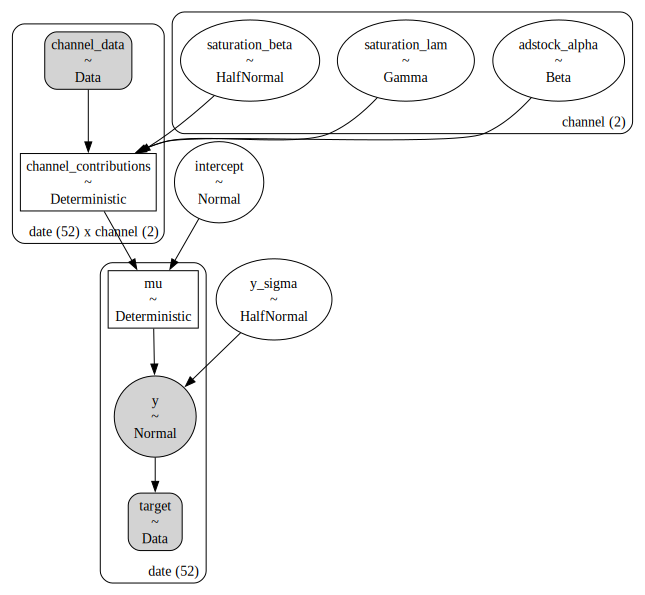

In [20]:
pm.model_to_graphviz(mmm.model)

And now we'll add the lift test measurements to the model and see how our model graph has changed.

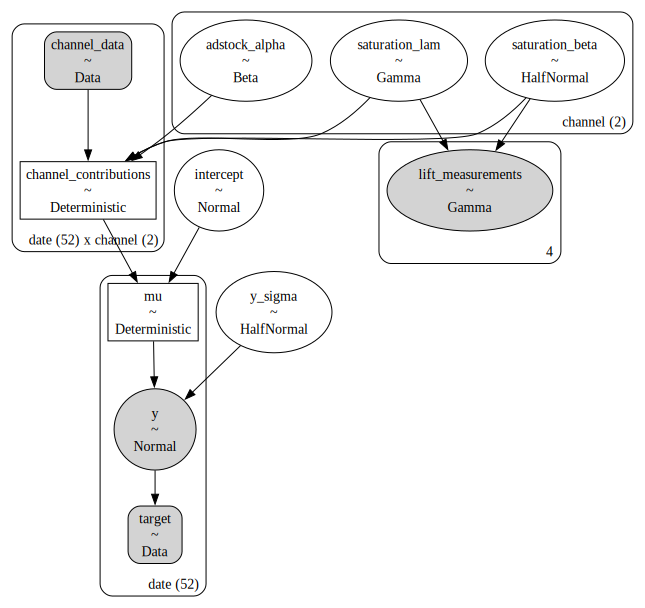

In [21]:
mmm.add_lift_test_measurements(df_lift_test)

pm.model_to_graphviz(mmm.model)

We can see the model graph is modified with new observation for our lift measurements. The observation distribution is assumed to be `Gamma` as each saturation curve is monotonically increasing given a set of parameters.

We can refit the model but with the lift tests included

In [22]:
idata_with = mmm.fit(X, y, **fit_kwargs)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The model gets shaped by the lift test measurements and the response curves begin to separate!

In [23]:
def plot_channel_rug(
    df: pd.DataFrame, color: str, ax: plt.Axes, height: float
) -> plt.Axes:
    for x in df["x"].to_numpy():
        ax.axvline(x, ymin=0, ymax=height, color=color)
    return ax


def plot_lift_test_rug(df, ax, height: float = 0.05) -> plt.Axes:
    idx = df["channel"] == "channel 1"
    plot_channel_rug(df.loc[idx], color="C0", ax=ax, height=height)
    plot_channel_rug(df.loc[~idx], color="C1", ax=ax, height=height)

    return ax

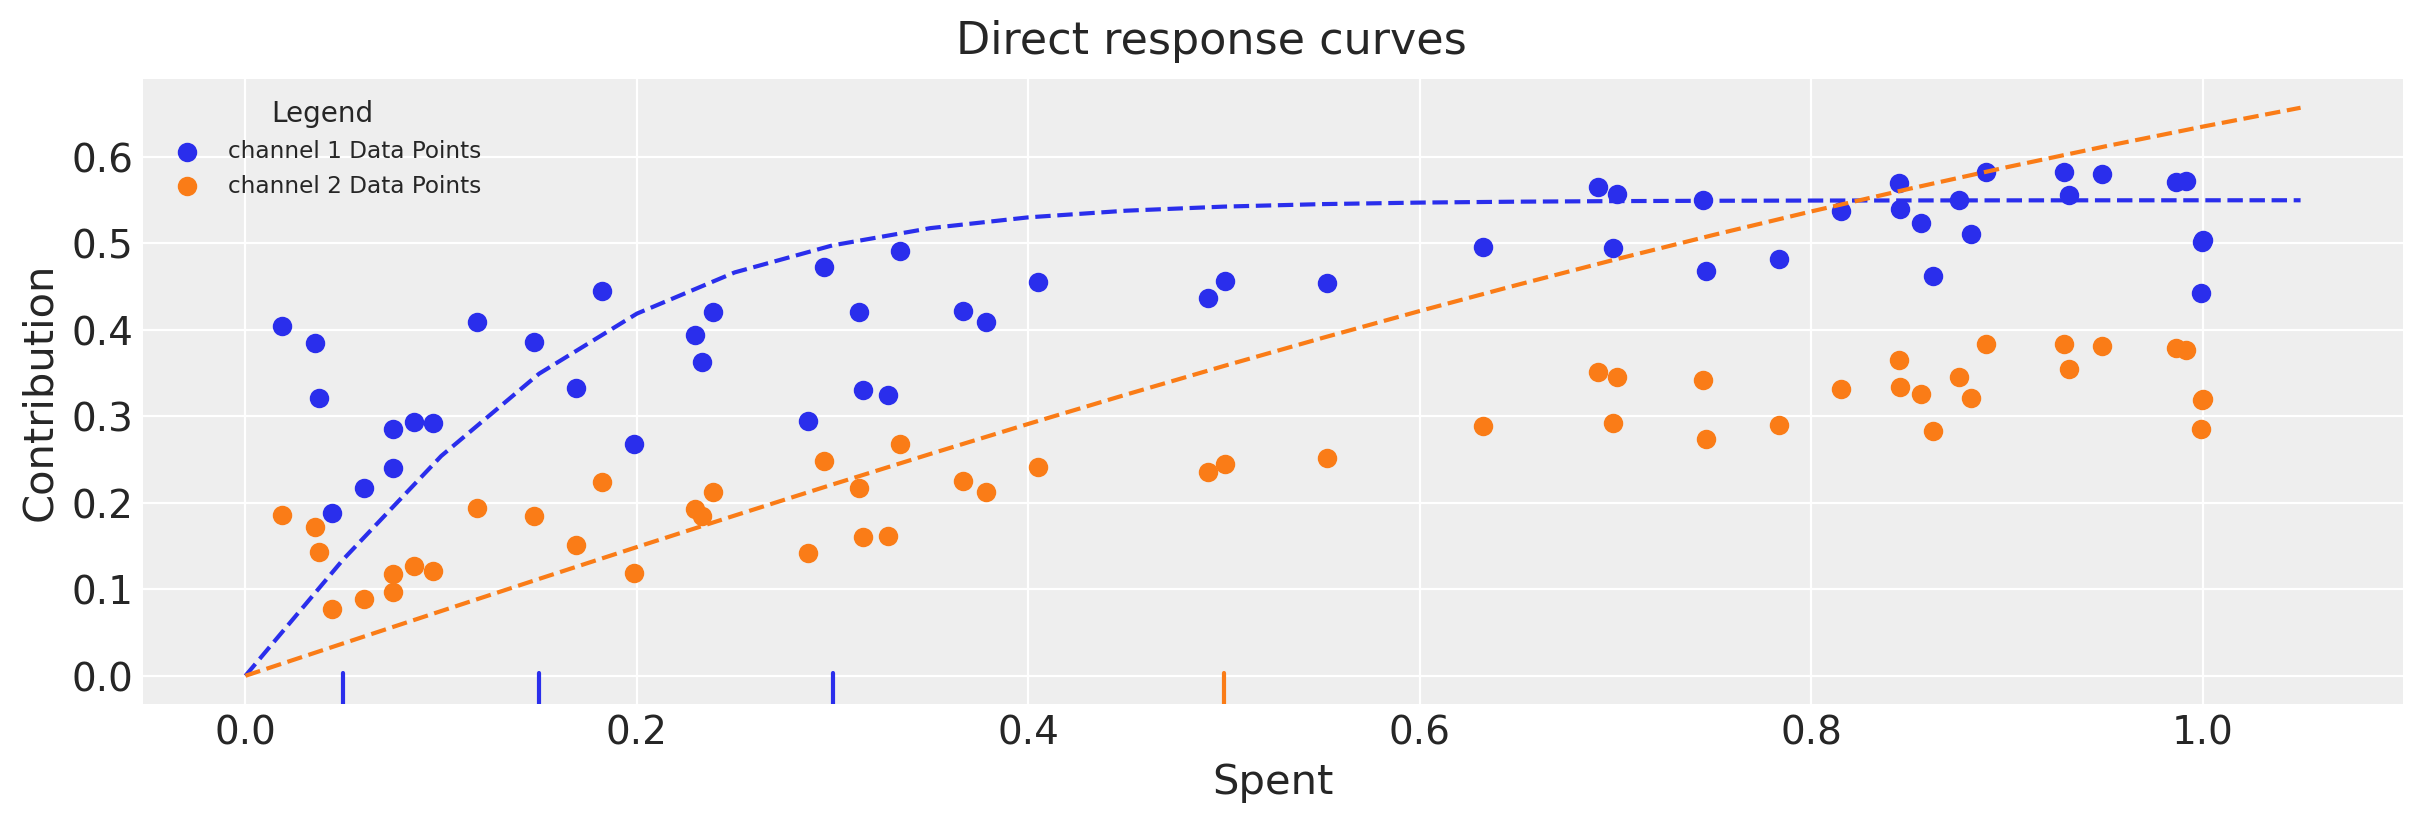

In [24]:
fig = mmm.plot_direct_contribution_curves(same_axes=True)
ax = fig.axes[0]
plot_actual_curves(ax=ax, linestyle="dashed")
plot_lift_test_rug(df_lift_test, ax);

The 'rug' marks in the plot above show the _initial_ channel spend before the lift test.

Below we show the (currently modest) changes in the saturation parameter estimates. The idea is that as we add more lift tests (see later), we can better estimate the saturation curves.

In [25]:
def plot_comparison(data, model_names, var_name: str) -> plt.Axes:
    return az.plot_forest(
        data,
        model_names=model_names,
        var_names=[var_name],
        combined=True,
        figsize=(8, 4),
    )[0]

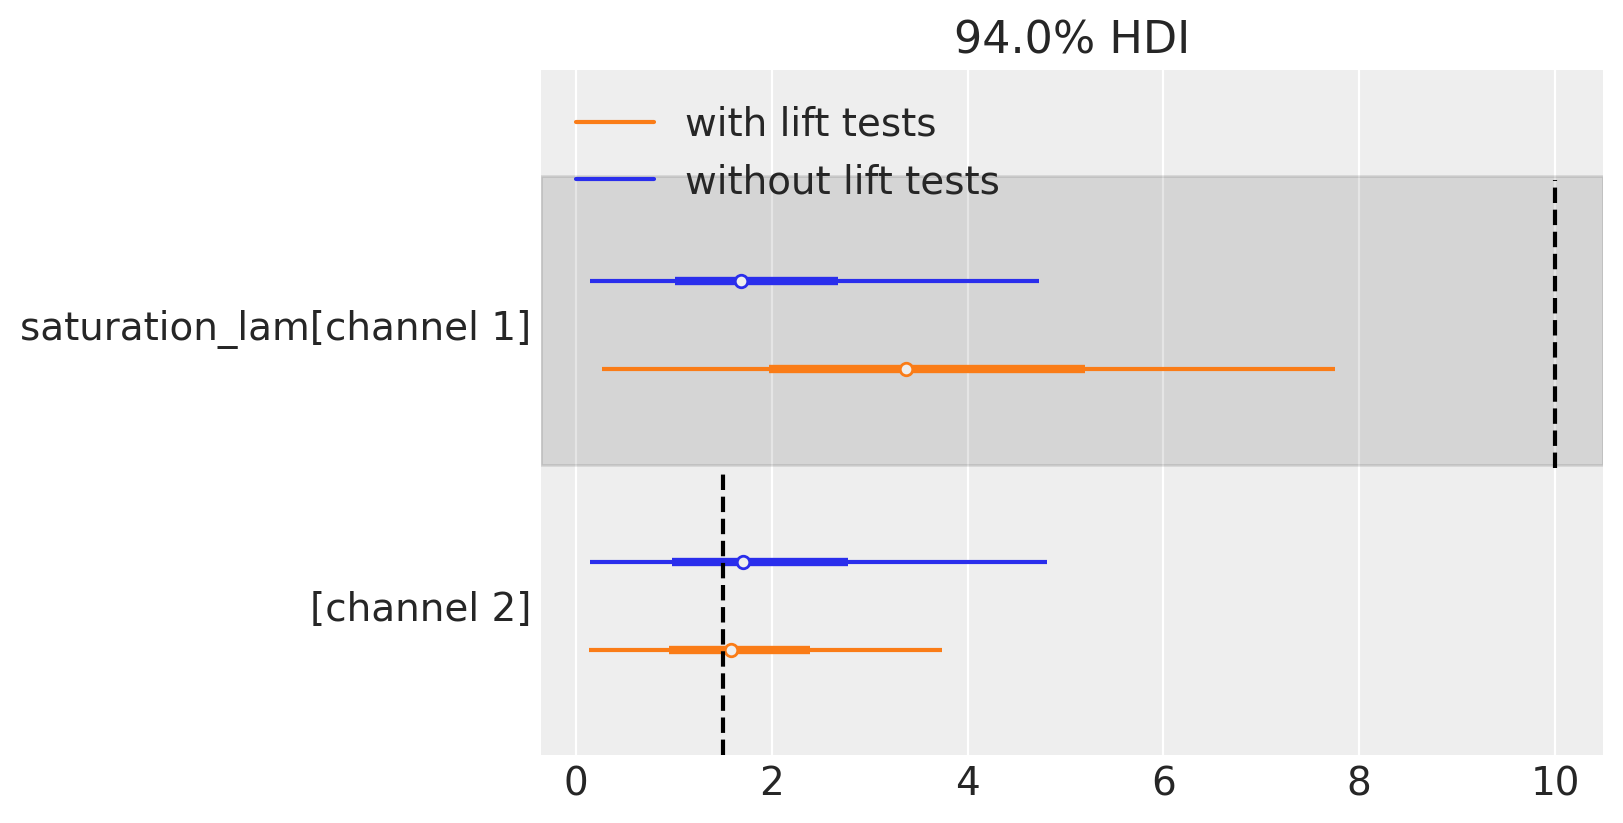

In [26]:
data = [idata_without, idata_with]
model_names = ["without lift tests", "with lift tests"]

ax = plot_comparison(data, model_names, "saturation_lam")
plot_true_value(true_lam_c1, "channel 1", ax)
plot_true_value(true_lam_c2, "channel 2", ax);

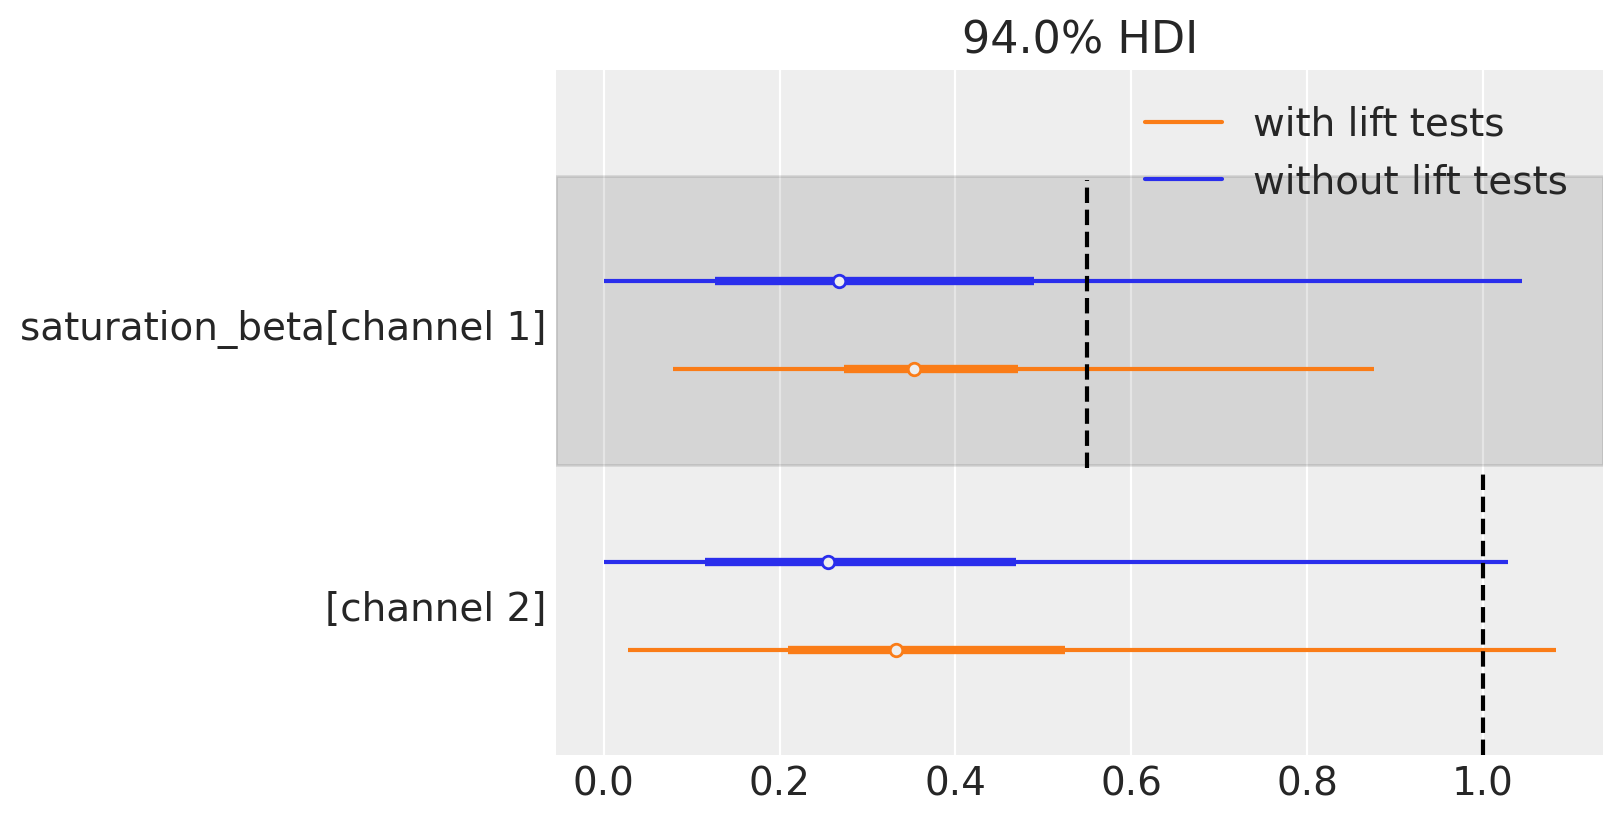

In [27]:
ax = plot_comparison(data, model_names, "saturation_beta")
plot_true_value(true_beta_c1, "channel 1", ax)
plot_true_value(true_beta_c2, "channel 2", ax);

Careful examination of these 2 plots shows that the posterior mean has shifted closer to the true parameter value and/or the HDI is shrinking, indicating improved precision of our estimates.

## Add Additional Lift Tests

We can add even more lift tests.

They can either all be added at one time or separately. 

In [28]:
df_additional_lift_test = pd.DataFrame(
    [
        # More for Channel x1
        create_lift_test_from_actual_curve("channel 1", 0.1, 0.05, sigma=0.01),
        create_lift_test_from_actual_curve("channel 1", 0.5, 0.05, sigma=0.01),
        # More for channel x2
        create_lift_test_from_actual_curve("channel 2", 0.3, 0.05, sigma=0.01),
    ]
)

df_additional_lift_test

,channel,x,delta_x,delta_y,sigma
0,channel 1,0.1,0.05,0.095167,0.01
1,channel 1,0.5,0.05,0.002885,0.01
2,channel 2,0.3,0.05,0.035354,0.01


Use the `name` parameter in order to separate the two sets of observations in the model graph.

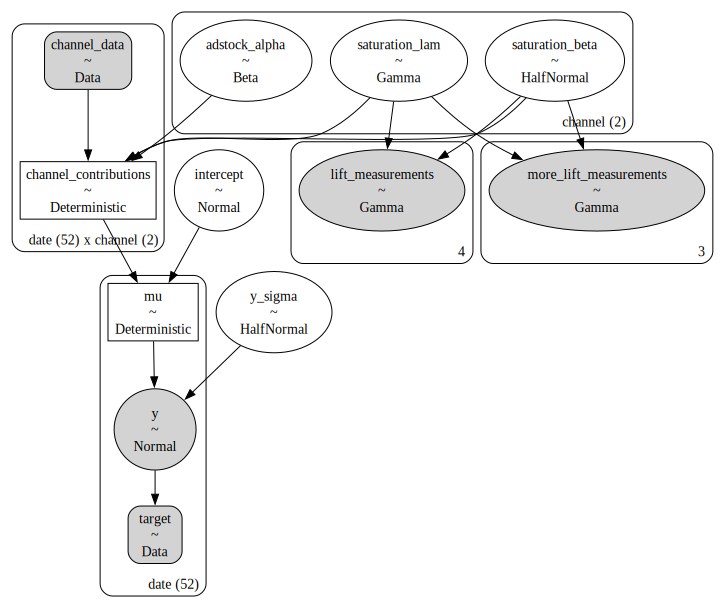

In [29]:
mmm.add_lift_test_measurements(df_additional_lift_test, name="more_lift_measurements")

pm.model_to_graphviz(mmm.model)

In [30]:
idata_with_more = mmm.fit(X, y, **fit_kwargs)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The response curve is shifting more and more

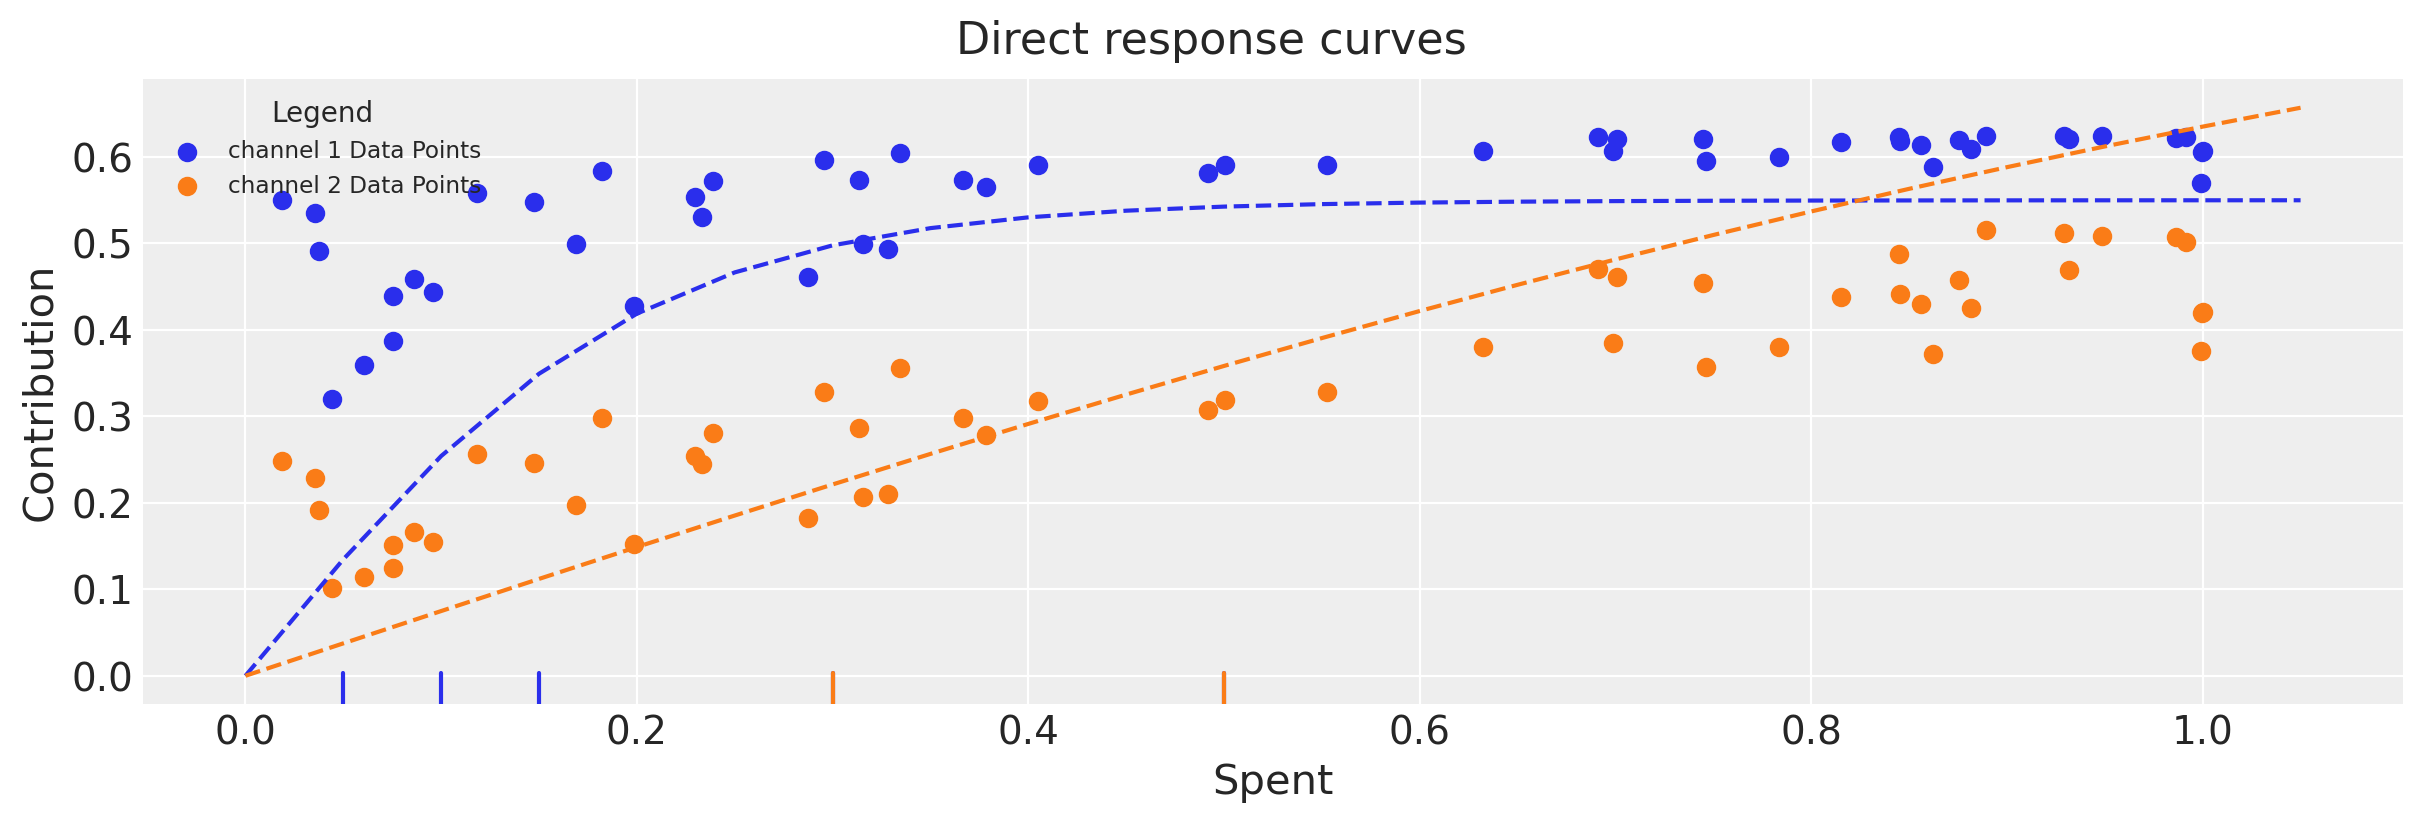

In [31]:
df_all_lift_tests = pd.concat([df_lift_test, df_additional_lift_test])

fig = mmm.plot_direct_contribution_curves(same_axes=True)
ax = fig.axes[0]
plot_actual_curves(ax=ax, linestyle="dashed")
plot_lift_test_rug(df_all_lift_tests, ax);

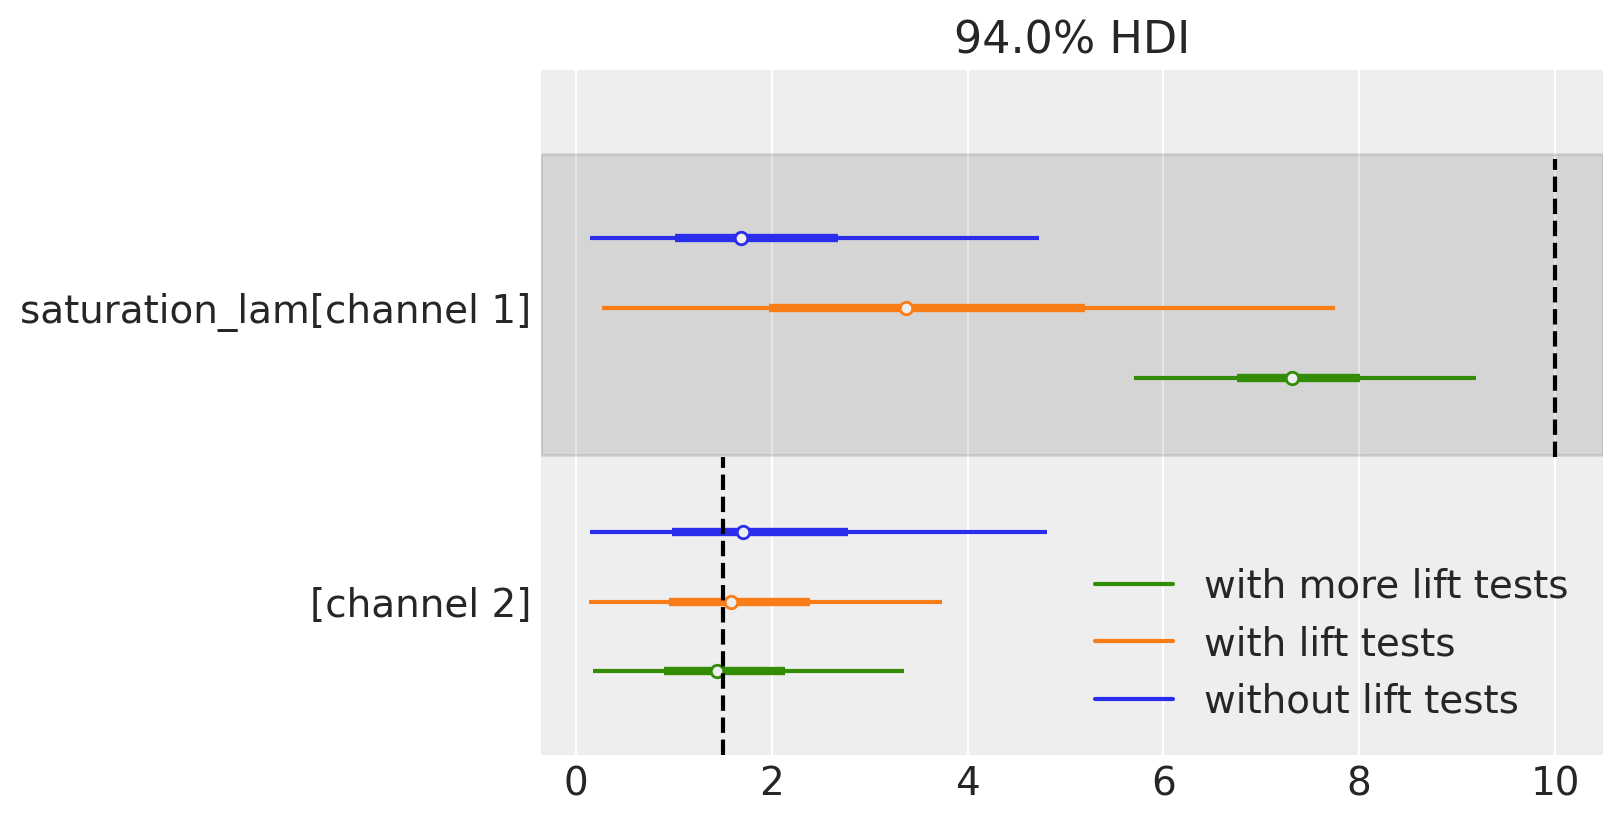

In [32]:
data = [idata_without, idata_with, idata_with_more]
model_names = ["without lift tests", "with lift tests", "with more lift tests"]

ax = plot_comparison(data, model_names, "saturation_lam")
plot_true_value(true_lam_c1, "channel 1", ax, split=0.435)
plot_true_value(true_lam_c2, "channel 2", ax, split=0.435);

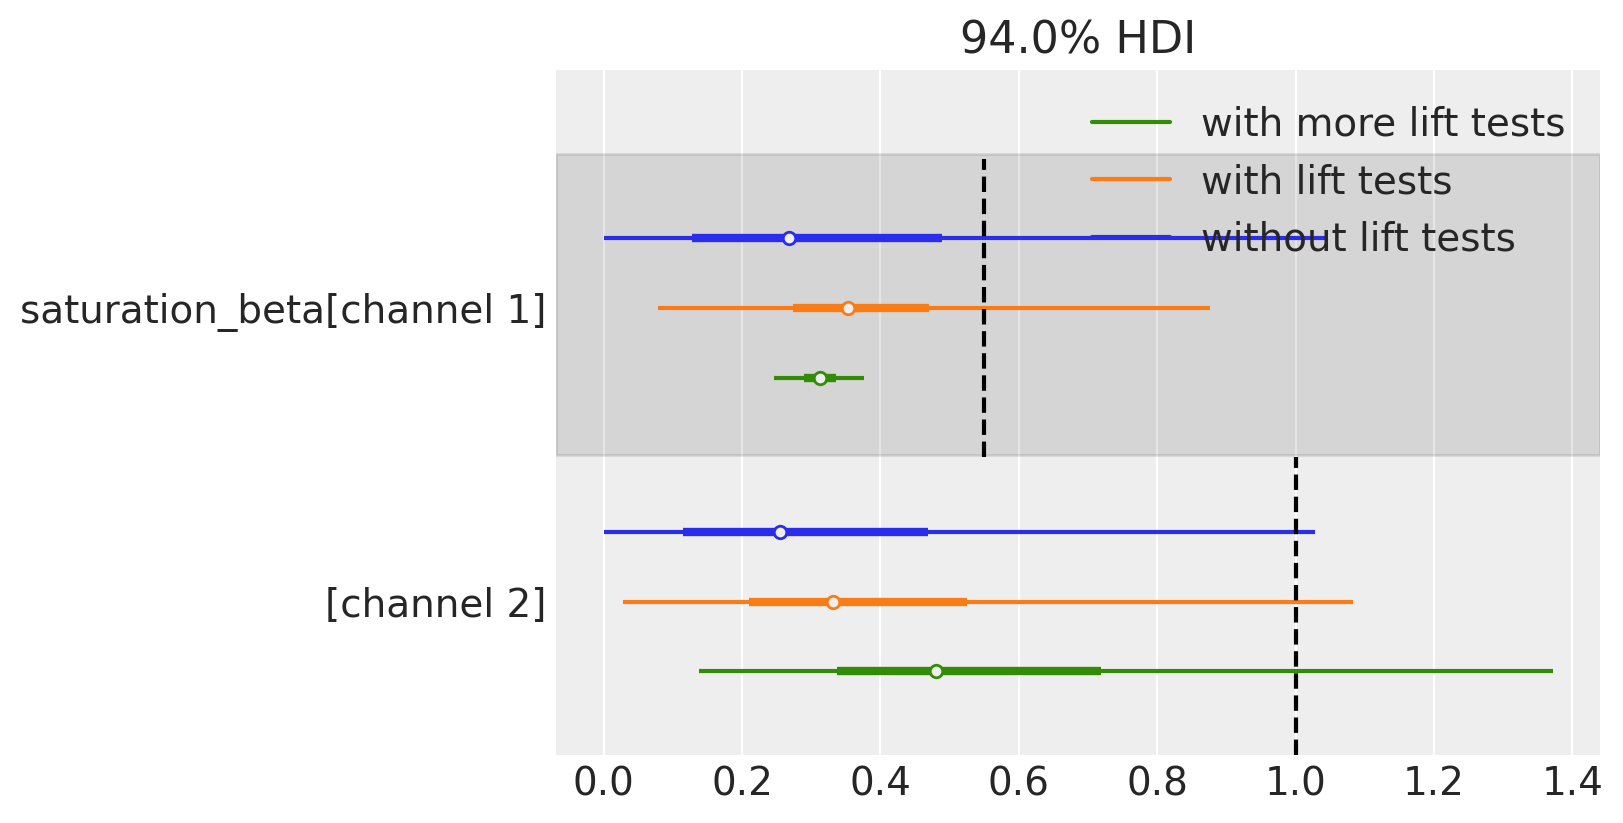

In [33]:
ax = plot_comparison(data, model_names, "saturation_beta")
plot_true_value(true_beta_c1, "channel 1", ax, split=0.435)
plot_true_value(true_beta_c2, "channel 2", ax, split=0.435);

So we can see in the 2 plots above that when we add even more lift test data to our MMM, the parameter estimates relating to the saturation curves are getting closer to the true values.

## Conclusion

The `add_lift_test_measurements` method can be used in order to incorporate experiments into our model likelihood and nudge the model parameters closer to the actuals in this example.

Conducting various experiments for each channel at various spends will bring the best results.

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor

Last updated: Thu Sep 05 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.26.0

pymc_marketing: 0.8.0
pytensor      : 2.22.1

pandas    : 2.2.2
pymc      : 5.15.1
numpy     : 1.26.4
matplotlib: 3.8.4
arviz     : 0.18.0

Watermark: 2.4.3

